## Using exported NetCDFs sliced in time/space
### time = 1950 -2050
### space = raster cells that intersect CA shp
* futher slice in space using a merged SoCal shp
* upweight using % land intersect
* re-draw time series plots for historial into future with trendlines
* get slopes of trendlines
* make SON and MAM geographic visuzaliations
* compare mean seasonal avg and year-seasons above and below for hist. and future 

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs
import cartopy.feature as cfeature
import seaborn  
import xarray as xr
import regionmask
import os
#this variable is only checked 
#at first import of GeoPandas.
#toggles on PYGEOS
#os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import earthpy 
import netCDF4 as nc
import cftime
#assists gpd with shp opening
import fiona #help(fiona.open)
import rasterio
import odc.geo.xr
#for clipping xarray 
import rioxarray as rio
from shapely.geometry import mapping
from shapely.geometry import Polygon
import rasterio
from affine import Affine
#import nc_time_axis
import cftime
from shapely.geometry import mapping, Polygon
import datetime
import warnings
from datetime import datetime, timedelta
#import regions
from osgeo import gdal,osr,ogr
import zarr
import fsspec

In [4]:
#opening netcdfs
#MAM
tas_hurs_101_mam_path = '/Users/jenniferbadger/Dropbox/Climatology/net_CDF_products/tas_hurs_101_mam.nc'
tas_hurs_101_mam  = nc.Dataset(tas_hurs_101_mam_path)

#SON
tas_hurs_101_son_path = '/Users/jenniferbadger/Dropbox/Climatology/net_CDF_products/tas_hurs_101_mam.nc'
tas_hurs_101_son = nc.Dataset(tas_hurs_101_son_path)

In [5]:
print(tas_hurs_101_mam)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    cell_measures: area: areacella
    cell_methods: area: time: mean
    description: near-surface (usually, 2 meter) air temperature
    frequency: mon
    id: tas
    long_name: Near-Surface Air Temperature
    mipTable: Amon
    out_name: tas
    prov: Amon ((isd.003))
    realm: atmos
    standard_name: air_temperature
    time: time
    time_label: time-mean
    time_title: Temporal mean
    title: Near-Surface Air Temperature
    type: real
    variable_id: tas
    units: K
    dimensions(sizes): y(11), x(10), time(303), member_id(3), dcpp_init_year(1)
    variables(dimensions): float64 y(y), float64 x(x), int64 time(time), float64 lon(x, y), float64 lat(x, y), <class 'str'> member_id(member_id), float64 dcpp_init_year(dcpp_init_year), int64 spatial_ref(), float32 tas(member_id, dcpp_init_year, time, y, x), float32 hurs(member_id, dcpp_init_year, time, y, x)
    groups: 


In [6]:
tas_hurs_101_mam = xr.open_dataset(tas_hurs_101_mam_path, decode_times= True, use_cftime= True, decode_coords="all")

/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_54384/2591190442.py:1: UserWarning: Variable(s) referenced in bounds not in variables: ['lat_bnds']
  tas_hurs_101_mam = xr.open_dataset(tas_hurs_101_mam_path, decode_times= True, use_cftime= True, decode_coords="all")
/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_54384/2591190442.py:1: UserWarning: Variable(s) referenced in bounds not in variables: ['time_bnds']
  tas_hurs_101_mam = xr.open_dataset(tas_hurs_101_mam_path, decode_times= True, use_cftime= True, decode_coords="all")
/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_54384/2591190442.py:1: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  tas_hurs_101_mam = xr.open_dataset(tas_hurs_101_mam_path, decode_times= True, use_cftime= True, decode_coords="all")


In [7]:
print(tas_hurs_101_mam) #time = 303 months= 101 yrs * 3 months


<xarray.Dataset>
Dimensions:         (y: 11, x: 10, time: 303, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 ...
Data variables:
    tas             (member_id, dcpp_init_year, time, y, x) float32 ...
    hurs            (member_id, dcpp_init_year, time, y, x) float32 ...
Attributes: (12/18)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    ...  

In [8]:
print("Time Period start:", tas_hurs_101_mam.time.min().values)
print("Time Period end:", tas_hurs_101_mam.time.max().values)

Time Period start: 1950-03-15 12:00:00
Time Period end: 2050-05-15 12:00:00


In [9]:
tas_hurs_101_son = xr.open_dataset(tas_hurs_101_son_path, decode_times= True, use_cftime= True, decode_coords="all")
print(tas_hurs_101_son)

<xarray.Dataset>
Dimensions:         (y: 11, x: 10, time: 303, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 ...
Data variables:
    tas             (member_id, dcpp_init_year, time, y, x) float32 ...
    hurs            (member_id, dcpp_init_year, time, y, x) float32 ...
Attributes: (12/18)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    ...  

/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_54384/1725002389.py:1: UserWarning: Variable(s) referenced in bounds not in variables: ['lat_bnds']
  tas_hurs_101_son = xr.open_dataset(tas_hurs_101_son_path, decode_times= True, use_cftime= True, decode_coords="all")
/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_54384/1725002389.py:1: UserWarning: Variable(s) referenced in bounds not in variables: ['time_bnds']
  tas_hurs_101_son = xr.open_dataset(tas_hurs_101_son_path, decode_times= True, use_cftime= True, decode_coords="all")
/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_54384/1725002389.py:1: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  tas_hurs_101_son = xr.open_dataset(tas_hurs_101_son_path, decode_times= True, use_cftime= True, decode_coords="all")


In [13]:
print("Time Period start:", tas_hurs_101_son.time.min().values)
print("Time Period end:", tas_hurs_101_son.time.max().values)

Time Period start: 1950-03-15 12:00:00
Time Period end: 2050-05-15 12:00:00


In [14]:
#Cali counties
cali_county_shp = ("/Users/jenniferbadger/Dropbox/Climatology/Data_new/County_Boundaries.zip")
county_gdf = gpd.read_file(cali_county_shp)

#Socal counties
bight_counties_aoi=county_gdf[county_gdf['NAME'].isin(["SANTA BARBARA COUNTY", "VENTURA COUNTY", "LOS ANGELES COUNTY", "ORANGE COUNTY", "SAN DIEGO COUNTY"])]
bight_counties_aoi.drop([9,10], axis=0, inplace=True)
bight_counties_aoi = bight_counties_aoi.to_crs("EPSG:4326") 

bight_counties_aoi

/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_54384/3652494716.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bight_counties_aoi.drop([9,10], axis=0, inplace=True)


,OBJECTID,TYPE,NAME,ShapeSTAre,ShapeSTLen,geometry
1,15,Other County,ORANGE COUNTY,2.210048e+10,7.010162e+05,"POLYGON ((-117.91674 33.94708, -117.91673 33.9..."
4,18,Other County,SAN DIEGO COUNTY,1.057717e+11,1.933786e+06,"MULTIPOLYGON (((-116.26641 33.42815, -116.2832..."
6,20,Other County,SANTA BARBARA COUNTY,7.665691e+10,2.246257e+06,"MULTIPOLYGON (((-119.47275 34.90117, -119.4628..."
7,21,Other County,VENTURA COUNTY,5.177124e+10,1.229728e+06,"MULTIPOLYGON (((-118.88064 34.78914, -118.8804..."
8,22,LA County,LOS ANGELES COUNTY,1.102047e+11,2.284699e+06,"MULTIPOLYGON (((-117.73872 34.82325, -117.7342..."


In [15]:
bight_counties_aoi.iloc[0]

OBJECTID                                                     15
TYPE                                               Other County
NAME                                              ORANGE COUNTY
ShapeSTAre                                   22100480210.613281
ShapeSTLen                                        701016.219095
geometry      POLYGON ((-117.91673911862499 33.9470836173929...
Name: 1, dtype: object

In [16]:
bight_counties_aoi.iloc[4]

/Users/jenniferbadger/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:387: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/jenniferbadger/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:388: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/jenniferbadger/opt/anaconda3/lib/python3.8/site-packages/pandas/io/formats/printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = it

OBJECTID                                                     22
TYPE                                                  LA County
NAME                                         LOS ANGELES COUNTY
ShapeSTAre                                  110204668151.496094
ShapeSTLen                                       2284698.514535
geometry      (POLYGON ((-117.7387248021367 34.8232515375173...
Name: 8, dtype: object

In [17]:
bight_counties_aoi.iloc[0]

OBJECTID                                                     15
TYPE                                               Other County
NAME                                              ORANGE COUNTY
ShapeSTAre                                   22100480210.613281
ShapeSTLen                                        701016.219095
geometry      POLYGON ((-117.91673911862499 33.9470836173929...
Name: 1, dtype: object

In [18]:
bight_merged = bight_counties_aoi.unary_union

In [19]:
bight_merged

In [20]:
#adding state column to act as attribute to dissolve on
bight_counties_aoi = bight_counties_aoi.assign(state ='CA')

In [21]:
bight_counties_aoi

,OBJECTID,TYPE,NAME,ShapeSTAre,ShapeSTLen,geometry,state
1,15,Other County,ORANGE COUNTY,2.210048e+10,7.010162e+05,"POLYGON ((-117.91674 33.94708, -117.91673 33.9...",CA
4,18,Other County,SAN DIEGO COUNTY,1.057717e+11,1.933786e+06,"MULTIPOLYGON (((-116.26641 33.42815, -116.2832...",CA
6,20,Other County,SANTA BARBARA COUNTY,7.665691e+10,2.246257e+06,"MULTIPOLYGON (((-119.47275 34.90117, -119.4628...",CA
7,21,Other County,VENTURA COUNTY,5.177124e+10,1.229728e+06,"MULTIPOLYGON (((-118.88064 34.78914, -118.8804...",CA
8,22,LA County,LOS ANGELES COUNTY,1.102047e+11,2.284699e+06,"MULTIPOLYGON (((-117.73872 34.82325, -117.7342...",CA


In [22]:
bight_agg = bight_counties_aoi.dissolve(by='state', aggfunc = 'sum')

/Users/jenniferbadger/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [23]:
bight_agg

,geometry,OBJECTID,ShapeSTAre,ShapeSTLen
state,,,,
CA,"MULTIPOLYGON (((-119.53428 33.28530, -119.5342...",96,3.665050e+11,8.395486e+06


<AxesSubplot: >

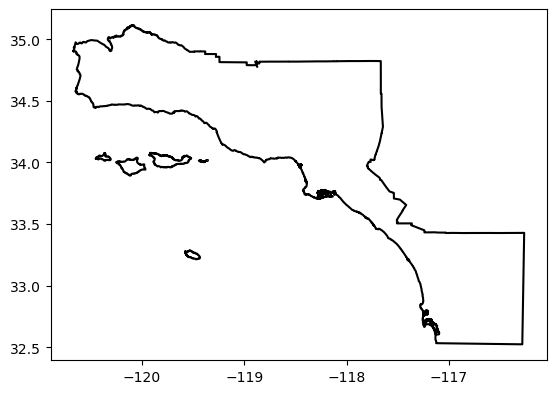

In [24]:
bight_agg.boundary.plot(color='k')

In [25]:
#Export merged geodataframe into shapefile
bight_agg.to_file("/Users/jenniferbadger/Dropbox/Climatology/Data_new/bight_agg.shp")

<AxesSubplot: >

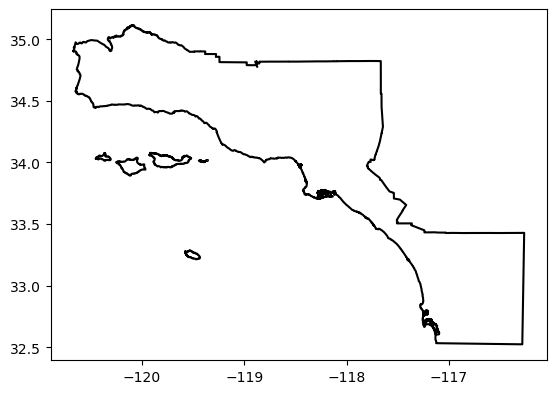

In [26]:
bight_agg = ("/Users/jenniferbadger/Dropbox/Climatology/Data_new/bight_agg.shp")
bight_gdf = gpd.read_file(bight_agg)

bight_gdf.boundary.plot(color='k')

In [27]:
tas_hurs_101_mam.dims

Frozen({'y': 11, 'x': 10, 'time': 303, 'member_id': 3, 'dcpp_init_year': 1})

In [28]:
tas_hurs_101_mam.coords

Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 ...

In [29]:
tas_hurs_101_mam.coords["lon"]

<xarray.DataArray 'lon' (x: 10, y: 11)>
[110 values with dtype=float64]
Coordinates:
  * y            (y) float64 32.51 33.46 34.4 35.34 ... 39.11 40.05 40.99 41.94
  * x            (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
    lon          (x, y) float64 ...
    lat          (x, y) float64 ...
    spatial_ref  int64 ...

In [30]:
#this makes a dictionary-like container of 
#coordinate arrays; needed for set_spatial_dims

tas_hurs_101_mam.coords["lon"] = tas_hurs_101_mam.lon
tas_hurs_101_mam.coords["lat"] = tas_hurs_101_mam.lat
tas_hurs_101_mam.coords["time"] = tas_hurs_101_mam.time

In [31]:
#MissingSpatialDimensionError: x dimension (lon) not found.
tas_hurs_101_mam.rio.set_spatial_dims(x_dim ="lon", y_dim ="lat", inplace=True)

MissingSpatialDimensionError: x dimension (lon) not found.

In [33]:
#lon is here under coords
#perhaps it's b/c lon is set to (x,y)
#or it b/c it isn't under dims
tas_hurs_101_mam.lon

<xarray.DataArray 'lon' (x: 10, y: 11)>
[110 values with dtype=float64]
Coordinates:
  * y            (y) float64 32.51 33.46 34.4 35.34 ... 39.11 40.05 40.99 41.94
  * x            (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
    lon          (x, y) float64 ...
    lat          (x, y) float64 ...
    spatial_ref  int64 ...

In [34]:
tas_hurs_101_mam.coords

Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 ...

In [35]:
tas_hurs_101_son.coords

Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 ...

In [36]:
#tasr4_1950_2014.coords["lon"] = ((tasr4_1950_2014.coords['lon'] + 180) % 360) - 180
#tasr4_1950_2014 = tasr4_1950_2014.sortby(["time", "lat", "lon"])

In [37]:
tas_hurs_101_mam.lon

<xarray.DataArray 'lon' (x: 10, y: 11)>
[110 values with dtype=float64]
Coordinates:
  * y            (y) float64 32.51 33.46 34.4 35.34 ... 39.11 40.05 40.99 41.94
  * x            (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
    lon          (x, y) float64 ...
    lat          (x, y) float64 ...
    spatial_ref  int64 ...

In [38]:
tas_hurs_101_mam.coords

Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 ...

In [39]:
tas_hurs_101_mam.dims

Frozen({'y': 11, 'x': 10, 'time': 303, 'member_id': 3, 'dcpp_init_year': 1})

In [40]:
clipped_bight = tas_hurs_101_mam.rio.clip(bight_gdf.geometry.apply(mapping), bight_gdf.crs, all_touched=True)

In [41]:
clipped_bight_son = tas_hurs_101_son.rio.clip(bight_gdf.geometry.apply(mapping), bight_gdf.crs, all_touched=True)

In [42]:
clipped_bight['tas']

<xarray.DataArray 'tas' (member_id: 3, dcpp_init_year: 1, time: 303, y: 4, x: 5)>
array([[[[[      nan,       nan,       nan, 289.13208, 290.7562 ],
          [      nan, 288.01218, 288.34906, 288.48816, 289.4422 ],
          [287.0251 , 287.61154, 287.58707, 286.9566 ,       nan],
          [286.63815, 286.59982, 285.6522 ,       nan,       nan]],

         [[      nan,       nan,       nan, 287.5101 , 289.4311 ],
          [      nan, 287.0255 , 287.26056, 287.13025, 288.74344],
          [286.27063, 286.64972, 286.78055, 286.52795,       nan],
          [285.90158, 285.48907, 284.8065 ,       nan,       nan]],

         [[      nan,       nan,       nan, 288.5458 , 291.49045],
          [      nan, 288.2244 , 288.4546 , 288.16217, 291.05344],
          [287.7111 , 288.4002 , 289.3934 , 289.91022,       nan],
          [287.57635, 287.87262, 288.1739 ,       nan,       nan]],

         ...,

         [[      nan,       nan,       nan, 290.59027, 292.1859 ],
          [      nan, 289.89935, 290.1187 , 289.92505, 291.3034 ],
          [289.07755, 289.36017, 289.3494 , 289.34723,       nan],
...
          [288.12167, 289.3027 , 291.41803, 292.63086,       nan],
          [288.01346, 288.74237, 290.15915,       nan,       nan]],

         ...,

         [[      nan,       nan,       nan, 287.47784, 288.36246],
          [      nan, 287.18033, 287.20755, 286.8017 , 287.4523 ],
          [286.54214, 286.68134, 286.3044 , 285.277  ,       nan],
          [286.11542, 285.463  , 283.8999 ,       nan,       nan]],

         [[      nan,       nan,       nan, 288.8204 , 292.11694],
          [      nan, 288.33258, 288.9169 , 288.84735, 291.5933 ],
          [287.582  , 288.33505, 289.73895, 290.58698,       nan],
          [287.68405, 287.721  , 289.18726,       nan,       nan]],

         [[      nan,       nan,       nan, 290.45593, 296.95132],
          [      nan, 290.68146, 291.06998, 291.96863, 296.80008],
          [289.96243, 292.29883, 294.84378, 296.46686,       nan],
          [290.51126, 292.79025, 294.9711 ,       nan,       nan]]]]],
      dtype=float32)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Attributes: (12/17)
    cell_methods:   area: time: mean
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas
    units:          K

In [43]:
clipped_bight_son['hurs']

<xarray.DataArray 'hurs' (member_id: 3, dcpp_init_year: 1, time: 303, y: 4, x: 5)>
array([[[[[      nan,       nan,       nan, 68.649284, 47.793865],
          [      nan, 76.00215 , 72.175354, 58.4132  , 48.585583],
          [78.92481 , 66.08567 , 54.06281 , 45.872955,       nan],
          [76.34229 , 61.801285, 49.727623,       nan,       nan]],

         [[      nan,       nan,       nan, 74.13426 , 56.53878 ],
          [      nan, 76.1285  , 73.22483 , 67.55487 , 56.103733],
          [76.80136 , 68.98235 , 59.23069 , 52.43051 ,       nan],
          [74.58842 , 68.32283 , 57.70484 ,       nan,       nan]],

         [[      nan,       nan,       nan, 78.13314 , 58.03221 ],
          [      nan, 78.716   , 76.686386, 74.40401 , 58.863235],
          [79.652   , 70.99715 , 59.23966 , 51.32871 ,       nan],
          [77.6652  , 70.35975 , 57.896988,       nan,       nan]],

         ...,

         [[      nan,       nan,       nan, 74.07601 , 53.76209 ],
          [      nan, 78.27685 , 74.94621 , 66.55535 , 53.297222],
          [79.828064, 70.26347 , 58.710438, 48.29762 ,       nan],
...
          [78.6198  , 67.85887 , 51.355766, 40.687225,       nan],
          [74.60056 , 65.59311 , 49.65318 ,       nan,       nan]],

         ...,

         [[      nan,       nan,       nan, 76.631386, 61.166992],
          [      nan, 78.58286 , 76.01397 , 70.3775  , 61.10087 ],
          [78.69188 , 70.411026, 62.907776, 58.963985,       nan],
          [74.85738 , 67.57428 , 61.64578 ,       nan,       nan]],

         [[      nan,       nan,       nan, 80.03945 , 53.54222 ],
          [      nan, 81.59876 , 78.16622 , 72.980865, 54.45918 ],
          [83.3589  , 74.065384, 58.038223, 45.85449 ,       nan],
          [79.821304, 71.38202 , 51.48555 ,       nan,       nan]],

         [[      nan,       nan,       nan, 86.1335  , 48.245598],
          [      nan, 84.38894 , 83.18813 , 73.90384 , 48.579285],
          [84.85802 , 68.49294 , 52.391457, 41.395126,       nan],
          [78.56424 , 63.628345, 46.789375,       nan,       nan]]]]],
      dtype=float32)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Attributes: (12/17)
    cell_methods:   area: time: mean
    description:    This is the relative humidity with respect to liquid wate...
    frequency:      mon
    id:             hurs
    long_name:      Near-Surface Relative Humidity
    mipTable:       Amon
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Relative Humidity
    type:           real
    variable_id:    hurs
    units:          %

In [44]:
clipped_bight.mean("time")

<xarray.Dataset>
Dimensions:         (y: 4, x: 5, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    tas             (member_id, dcpp_init_year, y, x) float32 nan nan ... nan
    hurs            (member_id, dcpp_init_year, y, x) float32 nan nan ... nan

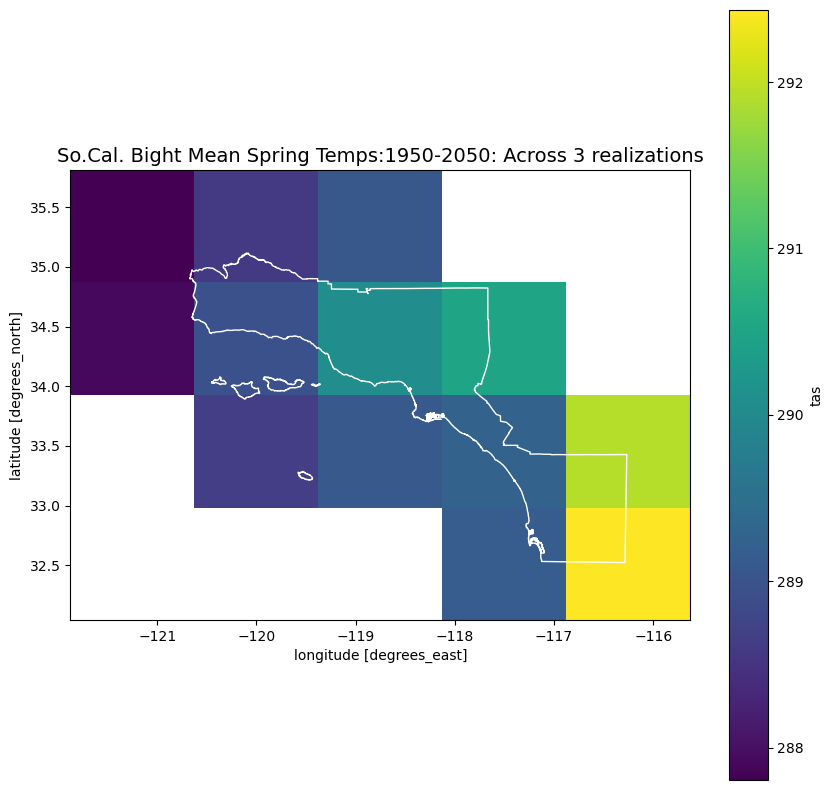

In [38]:
#writing CRS to xarray to match gdf
clipped_bight.rio.write_crs('EPSG:4326', inplace=True)

fig, ax = plt.subplots(figsize=(10 ,10))

clipped_bight['tas'].mean("time").mean('member_id').plot(ax=ax)
bight_gdf.plot(ax=ax, facecolor='none', edgecolor='white')
plt.title("So.Cal. Bight Mean Spring Temps:1950-2050: Across 3 realizations", fontsize=14, color= 'black')
plt.savefig('/Users/jenniferbadger/Dropbox/Climatology/presentation/tas_1950-2050.png')
#use vmin=vmin /vmax - vmax; ex vmin= 270.0, vmax = 287.5

In [39]:
print("Time Period start:", clipped_bight.time.min().values)
print("Time Period end:", clipped_bight.time.max().values)

Time Period start: 1950-03-15 12:00:00
Time Period end: 2050-05-15 12:00:00


In [40]:
clipped_bight.time

<xarray.DataArray 'time' (time: 303)>
array([cftime.DatetimeNoLeap(1950, 3, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1950, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1950, 5, 15, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2050, 3, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2050, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2050, 5, 15, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time         (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    spatial_ref  int64 0
Attributes:
    axis:           T
    standard_name:  time
    title:          time
    type:           double

In [41]:
clipped_bight


<xarray.Dataset>
Dimensions:         (y: 4, x: 5, time: 303, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    tas             (member_id, dcpp_init_year, time, y, x) float32 nan ... nan
    hurs            (member_id, dcpp_init_year, time, y, x) float32 nan ... nan
Attributes: (12/18)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas
    units:          K

In [42]:
clipped_bight_hist_tas = clipped_bight["tas"].sel(
    time=slice("1950-01-15", "2014-12-15"))

In [43]:
print("Time Period start:", clipped_bight_hist_tas.time.min().values)
print("Time Period end:", clipped_bight_hist_tas.time.max().values)

Time Period start: 1950-03-15 12:00:00
Time Period end: 2014-05-15 12:00:00


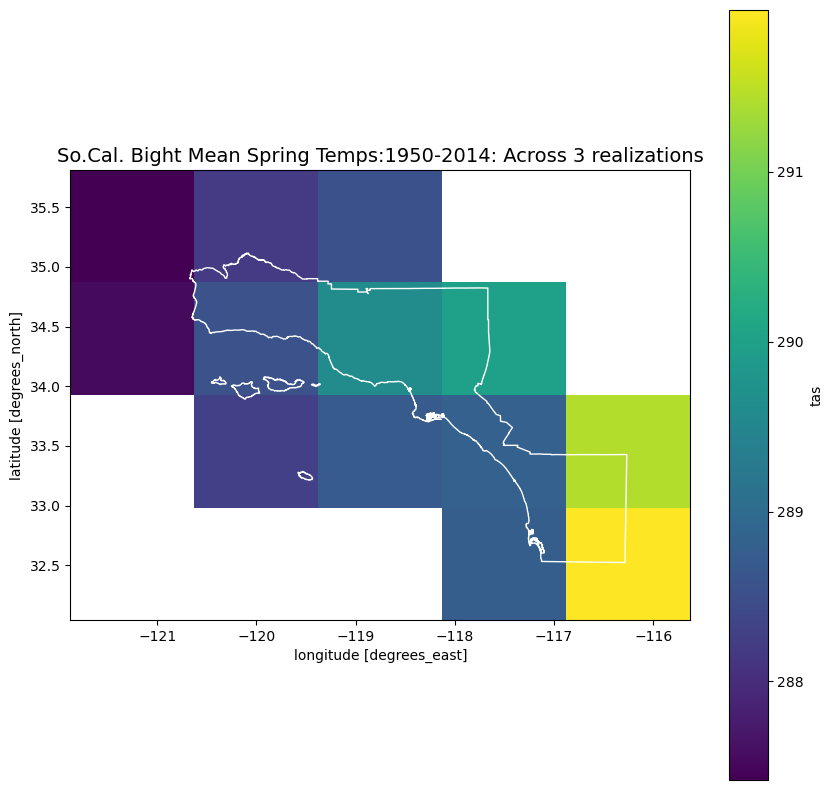

In [44]:
fig, ax = plt.subplots(figsize=(10 ,10))

clipped_bight_hist_tas.mean("time").mean('member_id').plot(ax=ax)
bight_gdf.plot(ax=ax, facecolor='none', edgecolor='white')
plt.title("So.Cal. Bight Mean Spring Temps:1950-2014: Across 3 realizations", fontsize=14, color= 'black')
plt.savefig('/Users/jenniferbadger/Dropbox/Climatology/presentation/tas_1950-2014.png')

In [45]:
clipped_bight_ssp245_tas = clipped_bight["tas"].sel(
    time=slice("2015-01-15", "2100-12-15"))

In [46]:
print("Time Period start:", clipped_bight_ssp245_tas.time.min().values)
print("Time Period end:", clipped_bight_ssp245_tas.time.max().values)

Time Period start: 2015-03-15 12:00:00
Time Period end: 2050-05-15 12:00:00


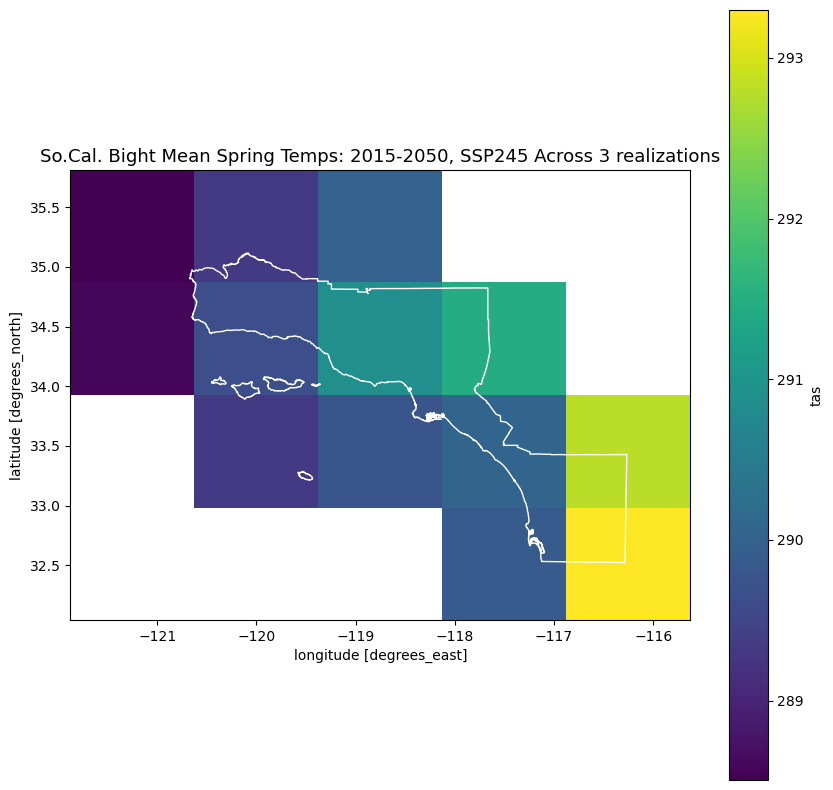

In [47]:
fig, ax = plt.subplots(figsize=(10 ,10))

clipped_bight_ssp245_tas.mean("time").mean('member_id').plot(ax=ax)
bight_gdf.plot(ax=ax, facecolor='none', edgecolor='white')
plt.title("So.Cal. Bight Mean Spring Temps: 2015-2050, SSP245 Across 3 realizations", fontsize=13, color= 'black')
plt.savefig('/Users/jenniferbadger/Dropbox/Climatology/presentation/tas_2015-2100.png')

In [48]:
#try upweighting raster cells that are fully inland: 
#this may help: https://docs.xarray.dev/en/stable/user-guide/computation.html
#this will likely help, also uses cosine of latitude
#https://docs.xarray.dev/en/stable/examples/area_weighted_temperature.html

#Can try assessing heatwaves and hurs at those time/dims:
#https://gist.github.com/ScottWales/dd9358bea2547c99e46b197bc9f53d21

#alternatively, after this is all accomplished, can try downscaling....
#tutorial: https://www.erikkusch.com/courses/krigr/projections/#obtaining-era5-land-data
#Data: 1950 - present temp @ 2m and relative humidty form temp dewpoint
#https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview


#this tutorial has a lot of potential as well
#https://geographicdata.science/book/notebooks/03_spatial_data.html

In [49]:
#convert to celsius
clipped_bight['tas'] = clipped_bight['tas'] - 273.15

In [50]:
clipped_bight.hurs.mean(("x", "y")).mean('time')

<xarray.DataArray 'hurs' (member_id: 3, dcpp_init_year: 1)>
array([[65.91886],
       [65.54628],
       [65.8422 ]], dtype=float32)
Coordinates:
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0

In [182]:
#for the weighted cells of a rectangular grid
#the cosine of the latitude is proportional to the 
#grid area
#np.cos = cosine
#np.deg2rad converst lat degrees to radians
lat_weights = np.cos(np.deg2rad(clipped_bight.y))
lat_weights.name = "lat_weights"
lat_weights

<xarray.DataArray 'lat_weights' (y: 4)>
array([0.84326868, 0.83431427, 0.82513415, 0.8157308 ])
Coordinates:
  * y            (y) float64 32.51 33.46 34.4 35.34
    spatial_ref  int64 0
Attributes:
    axis:           Y
    standard_name:  latitude
    title:          Latitude
    type:           double
    valid_max:      90.0
    valid_min:      -90.0
    units:          degrees_north
    long_name:      latitude

In [183]:
clipped_bight_weighted = clipped_bight.weighted(lat_weights)
clipped_bight_weighted

DatasetWeighted with weights along dimensions: y

In [184]:
mam_weighted_mean = clipped_bight_weighted.mean(("x", "y"))
mam_weighted_mean

<xarray.Dataset>
Dimensions:         (time: 303, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    tas             (member_id, dcpp_init_year, time) float64 14.73 ... 19.91
    hurs            (member_id, dcpp_init_year, time) float64 61.87 ... 66.23

In [185]:
mam_weighted_mean = clipped_bight_weighted.mean(("time"))
mam_weighted_mean

<xarray.Dataset>
Dimensions:         (y: 4, x: 5, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
    lon             (y, x) float64 238.8 240.0 241.2 242.5 ... 241.2 242.5 243.8
    lat             (y, x) float64 32.51 32.51 32.51 32.51 ... 35.34 35.34 35.34
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    tas             (member_id, dcpp_init_year, y, x) float64 nan nan ... nan
    hurs            (member_id, dcpp_init_year, y, x) float64 nan nan ... nan

In [186]:
mam_weighted_mean.tas.mean('member_id') #values are different, eg 17.35764497

<xarray.DataArray 'tas' (dcpp_init_year: 1, y: 4, x: 5)>
array([[[        nan,         nan,         nan, 16.00404971,
         19.28255531],
        [        nan, 15.49981303, 15.93598453, 16.10185495,
         18.76300059],
        [14.75341041, 15.80546971, 16.91814638, 17.35764497,
                 nan],
        [14.65699407, 15.44641946, 15.90409188,         nan,
                 nan]]])
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
    lon             (y, x) float64 238.8 240.0 241.2 242.5 ... 241.2 242.5 243.8
    lat             (y, x) float64 32.51 32.51 32.51 32.51 ... 35.34 35.34 35.34
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0

In [187]:
clipped_bight.tas.mean('time').mean('member_id') #values are different, eg 17.357643
#difference isn't just due to rounding

<xarray.DataArray 'tas' (dcpp_init_year: 1, y: 4, x: 5)>
array([[[      nan,       nan,       nan, 16.004051, 19.282555],
        [      nan, 15.499813, 15.935988, 16.10186 , 18.763002],
        [14.753411, 15.805472, 16.918146, 17.357643,       nan],
        [14.65699 , 15.446416, 15.904091,       nan,       nan]]],
      dtype=float32)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0

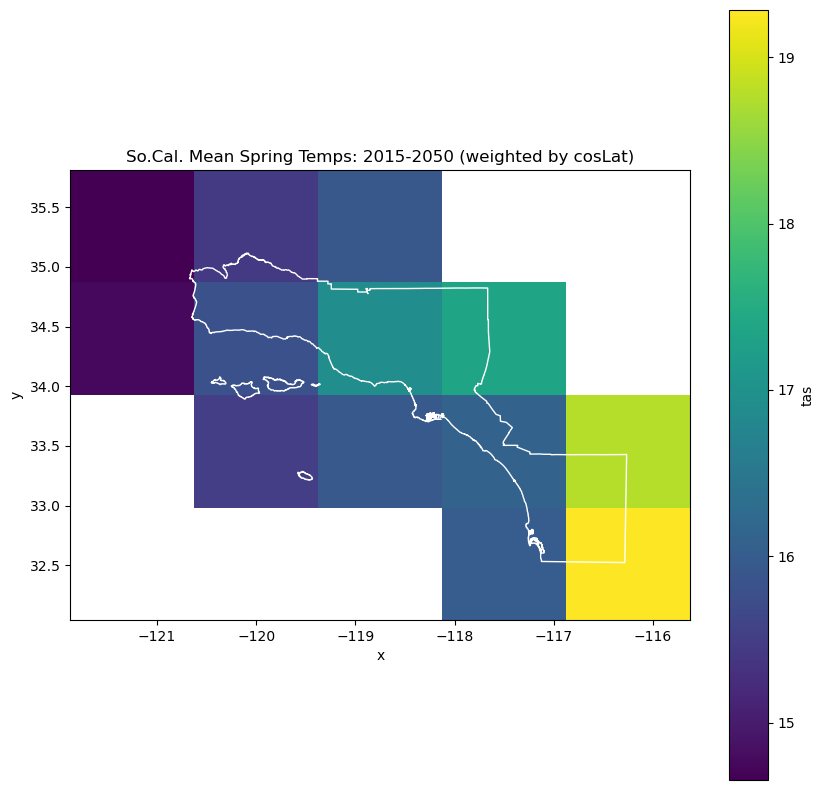

In [229]:
#doesn't plot after weights are applied
#lat/lon,  x/y are collapsed through mean(x,y)
#but variable tas is not callable from 
#the ds after weights are applied

fig, ax = plt.subplots(figsize=(10 ,10))

mam_weighted_mean.tas.mean('member_id').plot(ax=ax)
bight_gdf.plot(ax=ax, facecolor='none', edgecolor='white')
plt.title("So.Cal. Mean Spring Temps: 2015-2050 (weighted by cosLat)", fontsize=12, color= 'black')
plt.savefig('/Users/jenniferbadger/Dropbox/Climatology/presentation/tasw_2015-2050.png')

In [190]:
clipped_bight['tas'].mean("time").mean('member_id')

<xarray.DataArray 'tas' (dcpp_init_year: 1, y: 4, x: 5)>
array([[[      nan,       nan,       nan, 16.004051, 19.282555],
        [      nan, 15.499813, 15.935988, 16.10186 , 18.763002],
        [14.753411, 15.805472, 16.918146, 17.357643,       nan],
        [14.65699 , 15.446416, 15.904091,       nan,       nan]]],
      dtype=float32)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0

In [191]:
mam_weighted_mean.dtypes

Frozen({'tas': dtype('float64'), 'hurs': dtype('float64')})

In [192]:
 mam_weighted_mean.tas.dtype

dtype('float64')

In [61]:
mam_weighted_mean.dims

Frozen({'time': 303, 'member_id': 3, 'dcpp_init_year': 1})

In [194]:
mam_weighted_mean.coords

Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
    lon             (y, x) float64 238.8 240.0 241.2 242.5 ... 241.2 242.5 243.8
    lat             (y, x) float64 32.51 32.51 32.51 32.51 ... 35.34 35.34 35.34
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0

In [196]:
#accessing the shape 
#tuple(mam_weighted_mean.dims[d] for d in ['time', 'member_id', 'dcpp_init_year'])


In [197]:
#confirming dtype
print(type(mam_weighted_mean))

<class 'xarray.core.dataset.Dataset'>


In [198]:
#xarray before weights are applied
clipped_bight

<xarray.Dataset>
Dimensions:         (y: 4, x: 5, time: 303, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    tas             (member_id, dcpp_init_year, time, y, x) float32 nan ... nan
    hurs            (member_id, dcpp_init_year, time, y, x) float32 nan ... nan
Attributes: (12/18)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas
    units:          K

In [66]:
clipped_bight.dims

Frozen({'y': 4, 'x': 5, 'time': 303, 'member_id': 3, 'dcpp_init_year': 1})

In [67]:
#confimring shape- as above
tuple(clipped_bight.dims[d] for d in ['y', 'x', 'time', 'member_id', 'dcpp_init_year'])

(4, 5, 303, 3, 1)

In [68]:
clipped_bight.coords

Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0

In [104]:
#exporting to use in ArcGIS Pro
clipped_bight_path = '/Users/jenniferbadger/Dropbox/Climatology/clipped_bight.nc'
clipped_bight.to_netcdf(path=clipped_bight_path)

In [144]:
#land percent - could multiply 13 list  members by 1/13
#so the weights sum to less than one across 13 cells
list2 = [np.nan, np.nan,  np.nan,0.1284, 0.2305, 
        np.nan, 0.0069, 0.0451,0.3954, 0.2276,
        0.0011, 0.4919, 0.8226, 0.3372, np.nan,
        0.0024, 0.1297, 0.0009, np.nan,  np.nan]

np.nansum(list2) #2.8197

l = 1/13

list_whole = list(map(lambda x: x * l, list2))

np.nansum(list_whole) #0.2169

list_whole

[nan,
 nan,
 nan,
 0.009876923076923077,
 0.017730769230769234,
 nan,
 0.0005307692307692308,
 0.0034692307692307696,
 0.030415384615384615,
 0.017507692307692307,
 8.461538461538463e-05,
 0.03783846153846154,
 0.06327692307692308,
 0.02593846153846154,
 nan,
 0.0001846153846153846,
 0.009976923076923078,
 6.923076923076924e-05,
 nan,
 nan]

In [233]:
multiplier_first = xr.Dataset({"percent_land": (("y", "x"), np.array(list2).reshape(4,5),),},
        coords={"x": clipped_bight.x  , "y":clipped_bight.y, "time": clipped_bight.time},
)

#-121.2, -120.0, -118.8, -117.5 ,-116.2
#[32.51, 33.46 ,34.4, 35.34]
multiplier_first = multiplier_first.to_array()


In [234]:
multiplier_first

<xarray.DataArray (variable: 1, y: 4, x: 5)>
array([[[   nan,    nan,    nan, 0.1284, 0.2305],
        [   nan, 0.0069, 0.0451, 0.3954, 0.2276],
        [0.0011, 0.4919, 0.8226, 0.3372,    nan],
        [0.0024, 0.1297, 0.0009,    nan,    nan]]])
Coordinates:
  * x         (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
  * y         (y) float64 32.51 33.46 34.4 35.34
  * time      (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
  * variable  (variable) object 'percent_land'

In [235]:
multiplier_first.shape

(1, 4, 5)

In [236]:
clipped_bight_weighted_land = clipped_bight.weighted(multiplier_first.fillna(0))
clipped_bight_weighted_land

DatasetWeighted with weights along dimensions: variable, y, x

In [237]:
mam_weighted_mean_land = clipped_bight_weighted.mean(("time"))
mam_weighted_mean_land

<xarray.Dataset>
Dimensions:         (y: 4, x: 5, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
    lon             (y, x) float64 238.8 240.0 241.2 242.5 ... 241.2 242.5 243.8
    lat             (y, x) float64 32.51 32.51 32.51 32.51 ... 35.34 35.34 35.34
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    tas             (member_id, dcpp_init_year, y, x) float64 nan nan ... nan
    hurs            (member_id, dcpp_init_year, y, x) float64 nan nan ... nan

In [239]:
mam_weighted_mean_land_xy = clipped_bight_weighted.mean((['x', 'y']))
mam_weighted_mean_land_xy

<xarray.Dataset>
Dimensions:         (time: 303, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    tas             (member_id, dcpp_init_year, time) float64 14.73 ... 19.91
    hurs            (member_id, dcpp_init_year, time) float64 61.87 ... 66.23

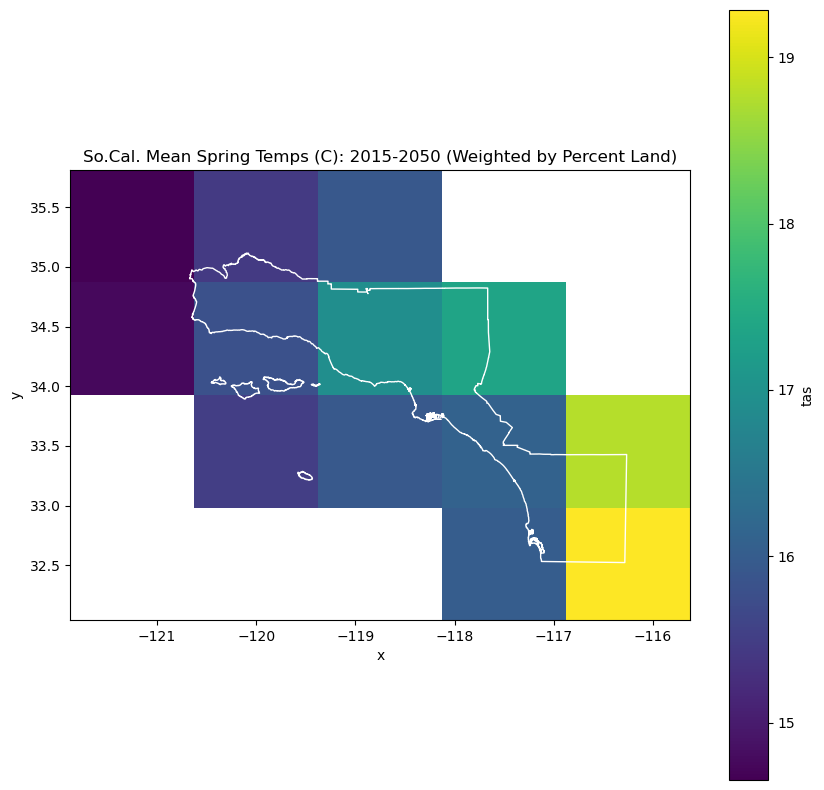

In [238]:
fig, ax = plt.subplots(figsize=(10 ,10))

mam_weighted_mean_land.tas.mean('member_id').plot(ax=ax)
bight_gdf.plot(ax=ax, facecolor='none', edgecolor='white')
plt.title("So.Cal. Mean Spring Temps (C): 2015-2050 (Weighted by Percent Land)", fontsize=12, color= 'black')
plt.savefig('/Users/jenniferbadger/Dropbox/Climatology/presentation/tas_land_2015-2050.png')

In [243]:
test = clipped_bight_weighted_land.mean(['x', 'y']).coarsen(time=3).mean()

test.mean('member_id')

<xarray.Dataset>
Dimensions:         (dcpp_init_year: 1, time: 101, variable: 1)
Coordinates:
  * time            (time) object 1950-04-15 00:00:00 ... 2050-04-15 00:00:00
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
  * variable        (variable) object 'percent_land'
Data variables:
    tas             (dcpp_init_year, time, variable) float64 15.54 ... 17.71
    hurs            (dcpp_init_year, time, variable) float64 59.49 ... 58.53

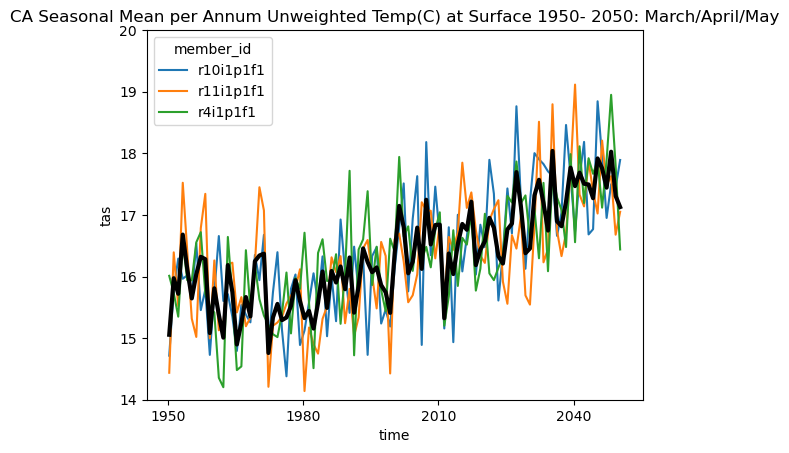

In [256]:
clipped_bight_xy = clipped_bight.mean(['x', 'y']).coarsen(time=3).mean()

plt.figure()
clipped_bight_xy.tas.plot(hue='member_id')
#average over all relizations
clipped_bight_xy.tas.mean('member_id').plot(color='k', linewidth=3, ylim=(14, 20))
plt.title('CA Seasonal Mean per Annum Unweighted Temp(C) at Surface 1950- 2050: March/April/May',
          fontsize=12,
          color="Black")

#trendline plots!
#plt.plot(times, y, color='c'f, linestyle='dashed', linewidth=3)

#savefig
plt.savefig('/Users/jenniferbadger/Dropbox/Climatology/presentation/bight_tas_noweights_MAM_plot.png', bbox_inches='tight', dpi = 100)

plt.show()

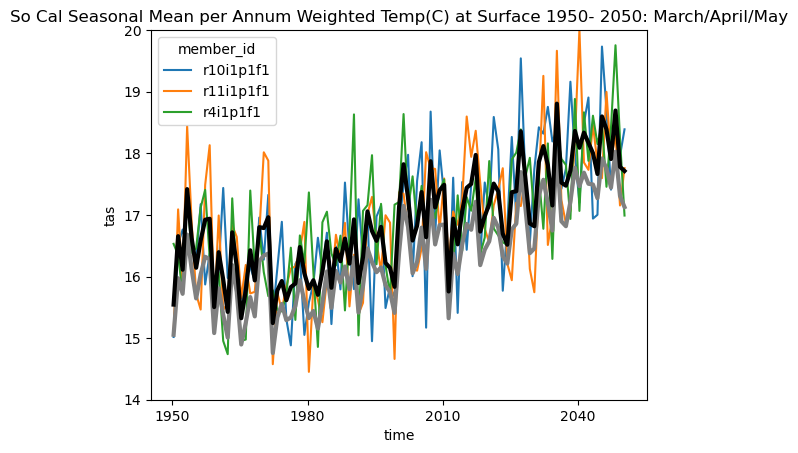

In [263]:
plt.figure()
test.tas.plot(hue='member_id')
#average over all relizations- unweighted
clipped_bight_xy.tas.mean('member_id').plot(color='gray', linewidth=3, ylim=(14, 20))
#average across realizaations - weighted according to land % 
test.tas.mean('member_id').plot(color='k', linewidth=3, ylim=(14, 20))
plt.title('So Cal Seasonal Mean per Annum Weighted Temp(C) at Surface 1950- 2050: March/April/May',
          fontsize=12,
          color="Black")

#trendline plots!
#plt.plot(times, y, color='c', linestyle='dashed', linewidth=3)

#savefig
plt.savefig('/Users/jenniferbadger/Dropbox/Climatology/presentation/bight_taswland_MAM_plot.png', bbox_inches='tight', dpi = 300)

plt.show()

In [207]:
mam_weighted_mean_land.tas.mean('member_id') #values are different, eg 17.35764497

<xarray.DataArray 'tas' (dcpp_init_year: 1, y: 4, x: 5)>
array([[[        nan,         nan,         nan, 16.00404971,
         19.28255531],
        [        nan, 15.49981303, 15.93598453, 16.10185495,
         18.76300059],
        [14.75341041, 15.80546971, 16.91814638, 17.35764497,
                 nan],
        [14.65699407, 15.44641946, 15.90409188,         nan,
                 nan]]])
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
    lon             (y, x) float64 238.8 240.0 241.2 242.5 ... 241.2 242.5 243.8
    lat             (y, x) float64 32.51 32.51 32.51 32.51 ... 35.34 35.34 35.34
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0

In [208]:
clipped_bight.tas.mean('time').mean('member_id')

<xarray.DataArray 'tas' (dcpp_init_year: 1, y: 4, x: 5)>
array([[[      nan,       nan,       nan, 16.004051, 19.282555],
        [      nan, 15.499813, 15.935988, 16.10186 , 18.763002],
        [14.753411, 15.805472, 16.918146, 17.357643,       nan],
        [14.65699 , 15.446416, 15.904091,       nan,       nan]]],
      dtype=float32)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34
  * x               (x) float64 -121.2 -120.0 -118.8 -117.5 -116.2
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0

In [ ]:
#merging temp and humidity for sept-oct-nov into one xarray
#tas_hurs_101_son = xr.merge(objects= (tas_101_son, hurs_101_son))